In [2]:
from numpy import *
import xarray as xr
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cmocean
import platform
from dask.diagnostics import ProgressBar
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

if platform.system() == 'Darwin':   # use 1/3° 2008-2011 B-SOSE output on local machine
    grid = xr.open_dataset('/Users/Ethan/Documents/Research/2016-08 - UW/Data/SOSE/grid.nc')
    sic = xr.open_dataset('/Users/Ethan/Documents/Research/2016-08 - UW/Data/SOSE/bsose_i105_2008to2012_monthly_SeaIceArea.nc')
    ncp = xr.open_dataset('/Users/Ethan/Documents/Research/2016-08 - UW/Data/SOSE/bsose_i105_2008to2012_monthly_NCP.nc')
elif platform.system() == 'Linux':  # use 1/6° 2008-2012 and 2013-2018 B-SOSE output on Deep
    grid = xr.open_dataset('/dat1/ethancc/Data/SOSE/grid.nc')
    sic = xr.open_mfdataset('/dat1/ethancc/Data/SOSE/bsose_*_monthly_SeaIceArea.nc',
                            combine='by_coords',concat_dim='time',chunks={'time':12,'XC':100,'YC':50})
    ncp = xr.open_mfdataset('/dat1/ethancc/Data/SOSE/bsose_*_monthly_NCP.nc',
                            combine='by_coords',concat_dim='time',chunks={'time':12,'XC':100,'YC':50})
    chl = xr.open_mfdataset('/dat1/ethancc/Data/SOSE/bsose_*_monthly_Chl.nc',
                            combine='by_coords',concat_dim='time',chunks={'time':12,'XC':100,'YC':50})

In [3]:
# define Weddell SIZ as all grid cells south of 48°S and between 60°W and 20°E featuring seasonal sea ice presence
weddell_mask = logical_and(grid['YC'] < -48,logical_or(grid['XC'] > 300,grid['XC'] < 20))
siz_mask = logical_and((sic['SIarea'].groupby('time.year',restore_coord_dims=True).max(dim='time') > 0.15).astype(float).mean(dim='year') > 0.5,
                       (sic['SIarea'].groupby('time.year',restore_coord_dims=True).min(dim='time') < 0.15).astype(float).mean(dim='year') > 0.5)
weddell_siz_mask = logical_and(weddell_mask,siz_mask.values)

# define Maud Rise region as 63°-67°S, 0°-10°E, per Campbell et al. 2019
mr_mask = logical_and(logical_and(grid['YC'] <= -63,grid['YC'] >= -67),logical_and(grid['XC'] >= 0,grid['XC'] <= 10))

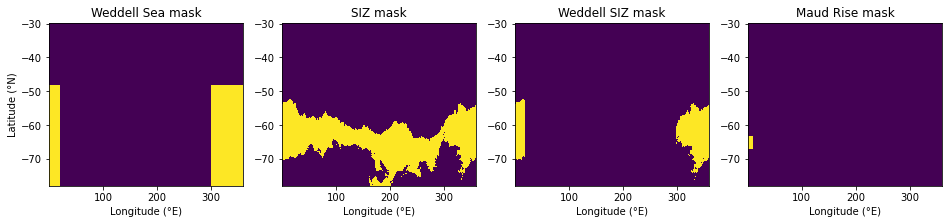

In [4]:
plt.figure(figsize=(16,3))
plt.subplot(1,4,1)
plt.pcolormesh(grid['XC'],grid['YC'],weddell_mask); plt.title('Weddell Sea mask'); plt.xlabel('Longitude (°E)'); plt.ylabel('Latitude (°N)');
plt.subplot(1,4,2)
plt.pcolormesh(grid['XC'],grid['YC'],siz_mask); plt.title('SIZ mask'); plt.xlabel('Longitude (°E)');
plt.subplot(1,4,3)
plt.pcolormesh(grid['XC'],grid['YC'],weddell_siz_mask); plt.title('Weddell SIZ mask'); plt.xlabel('Longitude (°E)');
plt.subplot(1,4,4)
plt.pcolormesh(grid['XC'],grid['YC'],mr_mask); plt.title('Maud Rise mask'); plt.xlabel('Longitude (°E)');

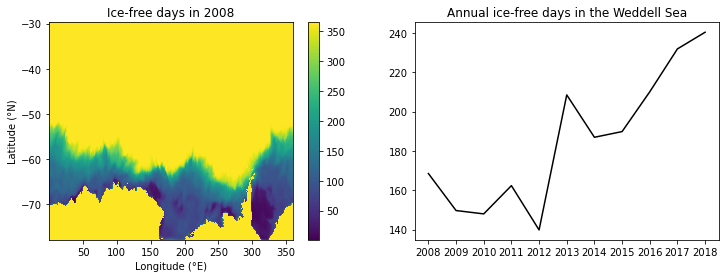

In [5]:
# calculate annual ice-free season length
# note: this is an approximation that assumes SIC is usually close to 0% or 100%, so (1 - monthly average SIC) can
#       be scaled to reasonably estimate ice-free days
annual_ice_free_days = 365.24/12 * (12 - sic['SIarea'].groupby('time.year',restore_coord_dims=True).sum())
annual_ice_free_days_weddell = pd.Series(index=annual_ice_free_days.year.values,
                                         data=[average(annual_ice_free_days.sel(year=year).values[weddell_siz_mask],
                                                       weights=sic['rA'].values[weddell_siz_mask])
                                               for year in annual_ice_free_days.year],
                                         dtype=float64)

# example plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.pcolormesh(grid['XC'],grid['YC'],annual_ice_free_days.sel(year=2008))
plt.title('Ice-free days in 2008'); plt.xlabel('Longitude (°E)'); plt.ylabel('Latitude (°N)'); plt.colorbar();
plt.subplot(1,2,2)
plt.plot(annual_ice_free_days_weddell,c='k')
plt.xticks(annual_ice_free_days.year.values)
plt.title('Annual ice-free days in the Weddell Sea');

In [6]:
# compute depth-integrated NCP, taking into account vertical grid cell size
# note: assume NCP is negligible below 500 m
ncp_column = (ncp['BLGNCP'] * ncp['drF']).sel(Z=slice(0,-500)).sum(dim='Z')
ncp_column.attrs['units'] = 'mol C/m2/s'
ncp_column.attrs['long_name'] = 'Net Community Production'

In [7]:
# compute ANCP
ancp_column = ncp_column.groupby('time.year',restore_coord_dims=True).sum() * 60 * 60 * 24 * 365.24
ancp_column.attrs['units'] = 'mol C/m2'
with ProgressBar(): 
    ancp_column_weddell = pd.Series(index=ancp_column.year.values,
                                    data=[sum((ancp_column * ancp_column['rA']).sel(year=year).values[weddell_siz_mask]) 
                                          / sum(ancp_column['rA'].values[weddell_siz_mask]) 
                                          for year in ancp_column.year],
                                    dtype=float64)
    ancp_column_weddell.attrs['units'] = 'mol C/m2'

# compute ANCP means over B-SOSE 2013-2018 period only
with ProgressBar(): ancp_column_mean = ancp_column.loc[2013:2018].mean(dim='year').load()
with ProgressBar(): ancp_column_area_mean = (ancp_column.loc[2013:2018] * ancp_column['rA']).mean(dim='year').load()

[########################################] | 100% Completed | 13.4s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed | 13.4s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed | 13.5s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed | 13.4s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed | 13.4s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed | 13.7s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed | 14.2s
[########################################] | 100% Completed |  0.6s
[########################################] | 100

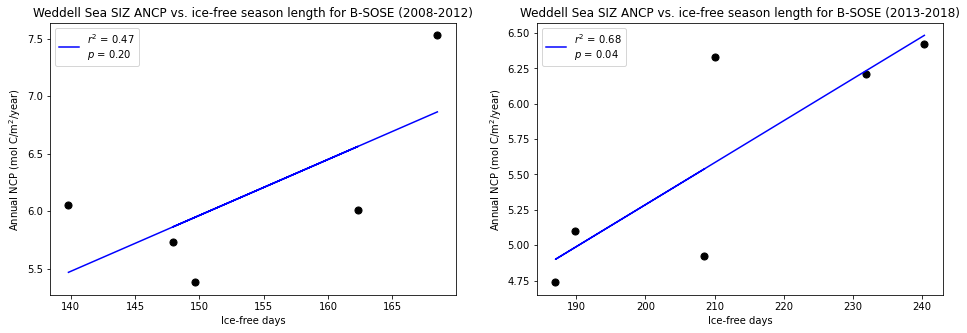

In [53]:
# compare ANCP and ice-free season length for Weddell Sea SIZ
if platform.system() == 'Darwin':
    plt.figure(figsize=(7,5))
    plt.scatter(annual_ice_free_days_weddell,ancp_column_weddell,c='k',s=50)
    plt.xlabel('Ice-free days'); plt.ylabel('Annual NCP (mol C/m2/year)')
    plt.title('Weddell Sea SIZ ANCP vs. ice-free season length');
if platform.system() == 'Linux':
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.scatter(annual_ice_free_days_weddell.loc[2008:2012],ancp_column_weddell.loc[2008:2012],c='k',s=50)
    slope, intercept, r_value, p_value, std_err \
        = stats.linregress(annual_ice_free_days_weddell.loc[2008:2012].values,
                           ancp_column_weddell.loc[2008:2012].values)
    plt.plot(annual_ice_free_days_weddell.loc[2008:2012].values,
             intercept + slope*annual_ice_free_days_weddell.loc[2008:2012].values,
             c='b',label='$r^2$ = {0:.2f}\n$p$ = {1:.2f}'.format(r_value**2,p_value))
    plt.legend()
    plt.xlabel('Ice-free days'); plt.ylabel('Annual NCP (mol C/m$^2$/year)'); plt.title('Weddell Sea SIZ ANCP vs. ice-free season length for B-SOSE (2008-2012)');
    
    plt.subplot(1,2,2)
    plt.scatter(annual_ice_free_days_weddell.loc[2013:2018],ancp_column_weddell.loc[2013:2018],c='k',s=50)
    plt.xlabel('Ice-free days'); plt.ylabel('Annual NCP (mol C/m$^2$/year)'); plt.title('Weddell Sea SIZ ANCP vs. ice-free season length for B-SOSE (2013-2018)');
    slope, intercept, r_value, p_value, std_err \
        = stats.linregress(annual_ice_free_days_weddell.loc[2013:2018].values,
                           ancp_column_weddell.loc[2013:2018].values)
    plt.plot(annual_ice_free_days_weddell.loc[2013:2018].values,
             intercept + slope*annual_ice_free_days_weddell.loc[2013:2018].values,
             c='b',label='$r^2$ = {0:.2f}\n$p$ = {1:.2f}'.format(r_value**2,p_value))
    plt.legend()
    
    export_fig = True
    if export_fig: plt.savefig('/dat1/ethancc/Git/Weddell_phyto_paper/bsose_weddell_siz_ancp_vs_ice_free.jpg',dpi=300)

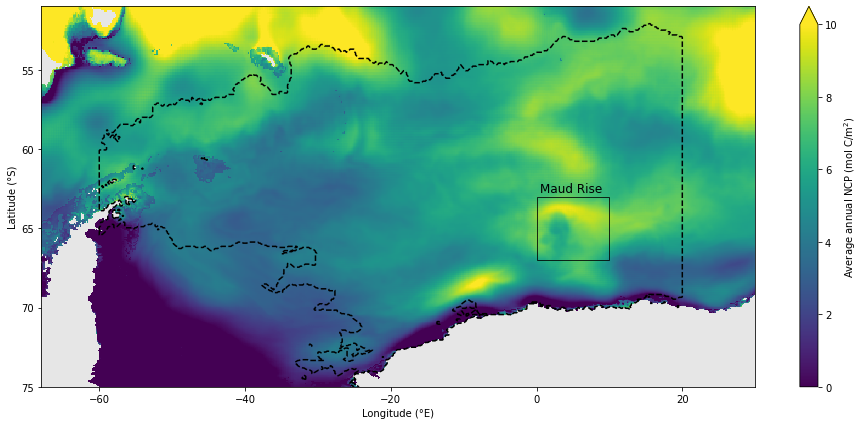

In [52]:
# see if Maud Rise (located in box) has an imprint in ANCP in B-SOSE (2013-2018 solution only)
if platform.system() == 'Darwin':  vmax = 25
elif platform.system() == 'Linux': vmax = 10

# roll longitudes from (180,360] to (-180,0] for ANCP data
roll_len = sum(ancp_column_mean['XC'].values > 180)
ancp_column_mean_rolled = ancp_column_mean.roll(shifts={'XC':roll_len},roll_coords=True)
XC_rolled = ancp_column_mean_rolled['XC'].values
XC_rolled[XC_rolled > 180] -= 360
ancp_column_mean_rolled = ancp_column_mean_rolled.assign_coords(XC=XC_rolled)

# roll longitudes similarly for Weddell SIZ mask
weddell_siz_mask_dataarray = ancp_column_mean.copy()
weddell_siz_mask_dataarray.values = weddell_siz_mask.astype(float)
weddell_siz_mask_rolled = weddell_siz_mask_dataarray.roll(shifts={'XC':roll_len},roll_coords=True)
XC_rolled = weddell_siz_mask_rolled['XC'].values
XC_rolled[XC_rolled > 180] -= 360
weddell_siz_mask_rolled = weddell_siz_mask_rolled.assign_coords(XC=XC_rolled)
    
# plot
ancp_column_mean_masked = ancp_column_mean_rolled.values
ancp_column_mean_masked[ancp_column_mean_rolled == 0.0] = NaN
cmap = plt.get_cmap('viridis')
cmap.set_bad('0.9')
plt.figure(figsize=(16,7))
plt.pcolormesh(ancp_column_mean_rolled['XC'],-1*ancp_column_mean_rolled['YC'],ancp_column_mean_masked,vmin=0,vmax=vmax,cmap=cmap)
plt.xlim([-68,30]); plt.gca().invert_yaxis(); plt.ylim([75,51]);
rect = mpatches.Rectangle((0,63),10,4,fill=False,alpha=0.8)
plt.gca().add_patch(rect)
plt.text(0.5,62.75,'Maud Rise',size=12)
cbar = plt.colorbar(extend='max');
cbar.set_label('Average annual NCP (mol C/m$^2$)')
plt.contour(weddell_siz_mask_rolled['XC'],-1*weddell_siz_mask_rolled['YC'],weddell_siz_mask_rolled,levels=[0.5],colors='k',linestyles='dashed',zorder=2)
plt.xlabel('Longitude (°E)'); plt.ylabel('Latitude (°S)');

export_fig = True
if export_fig and platform.system() == 'Linux': plt.savefig('/dat1/ethancc/Git/Weddell_phyto_paper/bsose_iter133_weddell_siz_ancp.jpg',dpi=300)

In [10]:
# calculate statistics for Maud Rise vs. entire Weddell Sea using only B-SOSE solution for 2013-2018
mr_average_ancp = average(ancp_column_mean.values[mr_mask],    # units: mol C/m2
                          weights=ancp_column['rA'].values[mr_mask])
weddell_average_ancp = average(ancp_column_mean.values[weddell_siz_mask],
                               weights=ancp_column['rA'].values[weddell_siz_mask])
mr_total_ancp = sum(ancp_column_area_mean.values[mr_mask])  # units: mol C
weddell_total_ancp = sum(ancp_column_area_mean.values[weddell_siz_mask])
mr_total_area = sum(ancp_column['rA'].values[mr_mask])  # units: m2
weddell_total_area = sum(ancp_column['rA'].values[weddell_siz_mask])  # units: m2

print('Note: statistics are averaged over 2013-2018 B-SOSE solution only\n')
print('Average ANCP within Maud Rise region: {0:.2f} mol C/m2'.format(mr_average_ancp))
print('Average ANCP within Weddell Sea SIZ: {0:.2f} mol C/m2'.format(weddell_average_ancp))
print('Average ANCP within Maud Rise region is {0:.2f}% higher than average within Weddell Sea SIZ\n'.format(100*(mr_average_ancp/weddell_average_ancp - 1)))
print('Total ANCP within Maud Rise region: {0:.2f} Tmol C'.format(mr_total_ancp/1e12))
print('Total ANCP within Weddell Sea SIZ: {0:.2f} Tmol C'.format(weddell_total_ancp/1e12))
print('Contribution of Maud Rise region to Weddell Sea ANCP: {0:.2f}%'.format(100*mr_total_ancp/weddell_total_ancp))
print('Contribution of Maud Rise region to Weddell Sea SIZ area: {0:.2f}%'.format(100*mr_total_area/weddell_total_area))

Note: statistics are averaged over 2013-2018 B-SOSE solution only

Average ANCP within Maud Rise region: 7.63 mol C/m2
Average ANCP within Weddell Sea SIZ: 5.62 mol C/m2
Average ANCP within Maud Rise region is 35.70% higher than average within Weddell Sea SIZ

Total ANCP within Maud Rise region: 1.60 Tmol C
Total ANCP within Weddell Sea SIZ: 36.36 Tmol C
Contribution of Maud Rise region to Weddell Sea ANCP: 4.39%
Contribution of Maud Rise region to Weddell Sea SIZ area: 3.23%


In [16]:
# compute ANCP means over B-SOSE 2013-2016 period only
with ProgressBar(): ancp_column_mean_without_polynya = ancp_column.loc[2013:2016].mean(dim='year').load()
with ProgressBar(): ancp_column_area_mean_without_polynya = (ancp_column.loc[2013:2016] * ancp_column['rA']).mean(dim='year').load()
    
# calculate statistics for Maud Rise vs. entire Weddell Sea using only B-SOSE solution for 2013-2016
mr_average_ancp = average(ancp_column_mean_without_polynya.values[mr_mask],    # units: mol C/m2
                          weights=ancp_column['rA'].values[mr_mask])
weddell_average_ancp = average(ancp_column_mean_without_polynya.values[weddell_siz_mask],
                               weights=ancp_column['rA'].values[weddell_siz_mask])
mr_total_ancp = sum(ancp_column_area_mean_without_polynya.values[mr_mask])  # units: mol C
weddell_total_ancp = sum(ancp_column_area_mean_without_polynya.values[weddell_siz_mask])
mr_total_area = sum(ancp_column['rA'].values[mr_mask])  # units: m2
weddell_total_area = sum(ancp_column['rA'].values[weddell_siz_mask])  # units: m2

print('\nNote: statistics are averaged over 2013-2016 B-SOSE solution only (excluding 2017-2018, which featured a bloom season following the simulated polynya)\n')
print('Average ANCP within Maud Rise region: {0:.2f} mol C/m2'.format(mr_average_ancp))
print('Average ANCP within Weddell Sea SIZ: {0:.2f} mol C/m2'.format(weddell_average_ancp))
print('Average ANCP within Maud Rise region is {0:.2f}% higher than average within Weddell Sea SIZ\n'.format(100*(mr_average_ancp/weddell_average_ancp - 1)))
print('Total ANCP within Maud Rise region: {0:.2f} Tmol C'.format(mr_total_ancp/1e12))
print('Total ANCP within Weddell Sea SIZ: {0:.2f} Tmol C'.format(weddell_total_ancp/1e12))
print('Contribution of Maud Rise region to Weddell Sea ANCP: {0:.2f}%'.format(100*mr_total_ancp/weddell_total_ancp))
print('Contribution of Maud Rise region to Weddell Sea SIZ area: {0:.2f}%'.format(100*mr_total_area/weddell_total_area))

[########################################] | 100% Completed | 57.7s
[########################################] | 100% Completed | 58.3s

Note: statistics are averaged over 2013-2016 B-SOSE solution only (excluding 2017-2018, which featured a bloom season following the simulated polynya)

Average ANCP within Maud Rise region: 7.11 mol C/m2
Average ANCP within Weddell Sea SIZ: 5.27 mol C/m2
Average ANCP within Maud Rise region is 34.90% higher than average within Weddell Sea SIZ

Total ANCP within Maud Rise region: 1.49 Tmol C
Total ANCP within Weddell Sea SIZ: 34.11 Tmol C
Contribution of Maud Rise region to Weddell Sea ANCP: 4.36%
Contribution of Maud Rise region to Weddell Sea SIZ area: 3.23%


/home/ethancc/.conda/envs/global_minimal/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/ethancc/.conda/envs/global_minimal/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Average ratio of maximum subsurface Chl to maximum near-surface Chl within SIZ: 1.16
Average frequency of subsurface Chl maxima within SIZ: 78.43%


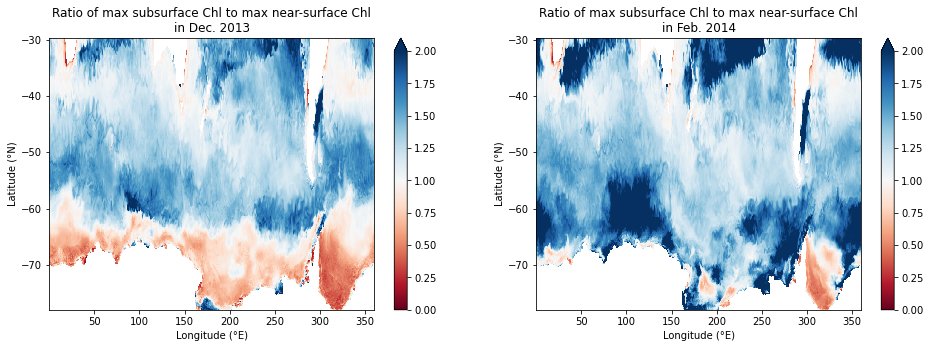

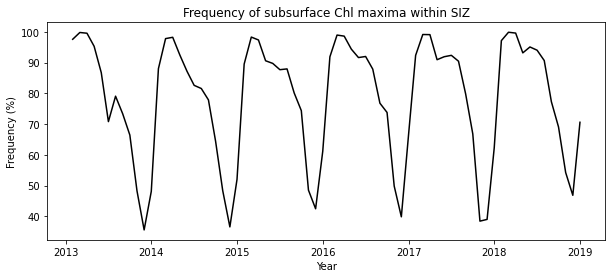

In [12]:
if platform.system() == 'Linux':
    # limit analysis to 2013-2018 B-SOSE solution; 2008-2012 shows some wacky variability
    chl = chl.sel(time=slice('2013','2018'))
    
    # estimate prevalence of subsurface Chl maxima in SIZ
    max_surf_chl = chl['BLGCHL'].sel(Z=slice(0,-20)).max(dim='Z')
    max_subsurf_chl = chl['BLGCHL'].sel(Z=slice(-20,-500)).max(dim='Z')
    dcm_ratio = (max_subsurf_chl / max_surf_chl).load()
    dcm_ratio_mean = dcm_ratio.mean(dim='time',skipna=True).load()
    avg_siz_dcm_ratio = average(dcm_ratio_mean.values[siz_mask],weights=chl['rA'].values[siz_mask])
    print('Average ratio of maximum subsurface Chl to maximum near-surface Chl within SIZ: {0:.02f}'.format(avg_siz_dcm_ratio))
    dcm_freq = (((dcm_ratio > 1.0) * dcm_ratio['rA']).where(siz_mask).sum(dim=['YC','XC']) / dcm_ratio['rA'].where(siz_mask).sum(dim=['YC','XC'])).load()
    print('Average frequency of subsurface Chl maxima within SIZ: {0:.02f}%'.format(100*dcm_freq.mean(dim='time').values))

    # plots
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.pcolormesh(grid['XC'],grid['YC'],dcm_ratio.sel(time='2013-12-31T14:20'),vmin=0,vmax=2,cmap='RdBu')
    plt.colorbar(extend='max');
    plt.title('Ratio of max subsurface Chl to max near-surface Chl\nin Dec. 2013'); plt.xlabel('Longitude (°E)'); plt.ylabel('Latitude (°N)');
    plt.subplot(1,2,2)
    plt.pcolormesh(grid['XC'],grid['YC'],dcm_ratio.sel(time='2014-03-02T11:00'),vmin=0,vmax=2,cmap='RdBu')
    plt.colorbar(extend='max');
    plt.title('Ratio of max subsurface Chl to max near-surface Chl\nin Feb. 2014'); plt.xlabel('Longitude (°E)'); plt.ylabel('Latitude (°N)');
    plt.figure(figsize=(10,4))
    plt.plot(dcm_freq['time'],dcm_freq.values*100,c='k')
    plt.title('Frequency of subsurface Chl maxima within SIZ'); plt.ylabel('Frequency (%)'); plt.xlabel('Year');